In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# MNIST veri setini yükle
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Hata kontrolü: Veri yüklenmiş mi?
assert x_train is not None and y_train is not None, "Veri seti yüklenemedi!"

# Veriyi düzleştir (28x28 -> 784 boyutuna)
x_train_flat = x_train.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

# Min-Max Normalizasyonu (0-1 aralığına)
x_train_normalized = x_train_flat / 255.0
x_test_normalized = x_test_flat / 255.0

# Eğitim ve doğrulama veri setini ayır
x_train, x_val, y_train, y_val = train_test_split(x_train_normalized, y_train, test_size=0.2, random_state=42)

# Sınıf etiketlerini kategorik hale getir
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [2]:
# RBF özel katmanını tanımla
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, num_centers, gamma):
        super(RBFLayer, self).__init__()
        self.num_centers = num_centers
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            shape=(self.num_centers, input_shape[-1]),
            initializer='random_normal',
            trainable=True,
            name="centers"
        )

    def call(self, inputs):
        diff = tf.expand_dims(inputs, 1) - self.centers
        return tf.exp(-self.gamma * tf.reduce_sum(tf.square(diff), axis=-1))

In [3]:
# RBF modelini tanımlayan fonksiyon
def create_rbf_model(num_centers, gamma):
    model = Sequential([
        RBFLayer(num_centers=num_centers, gamma=gamma),
        Dense(10, activation='softmax')  # Çıkış katmanı (10 sınıf için)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Grid Search parametreleri
rbf_params = {
    'num_centers': [100, 200],
    'gamma': [0.1, 0.01] # gamma küçük seçilirse merkezler daha dar olur.
}

best_accuracy = 0
best_params = None
best_rbf_model = None  # En iyi modeli saklamak için değişken oluşturduk

# Parametre kombinasyonlarını dene
for num_centers in rbf_params['num_centers']:
    for gamma in rbf_params['gamma']:
        # KMeans ile merkezleri belirle
        kmeans = KMeans(n_clusters=num_centers, random_state=42)
        kmeans.fit(x_train)

        centers = kmeans.cluster_centers_

        # Modeli oluştur ve eğit
        model = create_rbf_model(num_centers, gamma)
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                             epochs=10, batch_size=64, verbose=0)

        # Doğrulama setinde tahmin yap
        y_pred = np.argmax(model.predict(x_val), axis=1)
        y_true = np.argmax(y_val, axis=1)

        # Performans metriklerini hesapla
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        acc = accuracy_score(y_true, y_pred)

        print(f"Params: {num_centers}, Gamma: {gamma} -> Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        
        # En iyi modeli kaydet
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = (num_centers, gamma)
            best_rbf_model = model

# En iyi parametreleri yazdır
print(f"RBF için en iyi parametreler: {best_params} -> Acc: {best_accuracy:.4f}")


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Params: 100, Gamma: 0.1 -> Acc: 0.6957, Precision: 0.7800, Recall: 0.6885, F1: 0.7009
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Params: 100, Gamma: 0.01 -> Acc: 0.9004, Precision: 0.8992, Recall: 0.8994, F1: 0.8991
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Params: 200, Gamma: 0.1 -> Acc: 0.7883, Precision: 0.8427, Recall: 0.7845, F1: 0.7984
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Params: 200, Gamma: 0.01 -> Acc: 0.9107, Precision: 0.9102, Recall: 0.9099, F1: 0.9097
RBF için en iyi parametreler: (200, 0.01) -> Acc: 0.9107


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


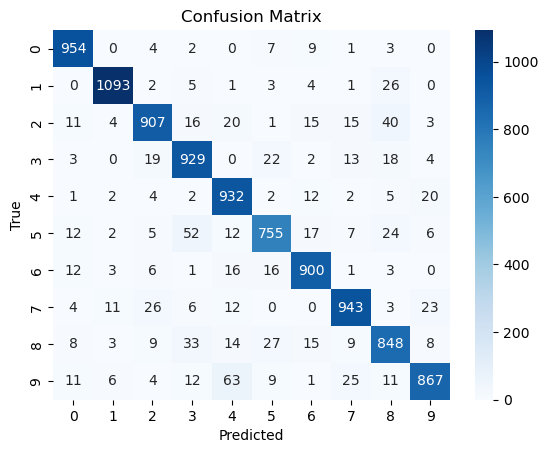


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.97      0.96      0.97      1135
           2       0.92      0.88      0.90      1032
           3       0.88      0.92      0.90      1010
           4       0.87      0.95      0.91       982
           5       0.90      0.85      0.87       892
           6       0.92      0.94      0.93       958
           7       0.93      0.92      0.92      1028
           8       0.86      0.87      0.87       974
           9       0.93      0.86      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [7]:
# Confusion Matrix ve Classification Report
y_pred_test = np.argmax(best_rbf_model.predict(x_test_normalized), axis=1)
y_true_test = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_test, y_pred_test))